# Gold Purification Prediction Model For Zyfra

This ducument will be a dissection of the gold purification process, for the end goal of predicting gold output from a sample of ore.

## Data Treatment

### Importing Libraries

In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

### Loading Data

In [3]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### Pre- Processing

In [4]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


Before we begin pre-processing, we want to see whether recovery calcuations are correct in the dataset

In [5]:
c_rough = gold_train['rougher.output.concentrate_au']
f_rough = gold_train['rougher.input.feed_au']
t_rough = gold_train['rougher.output.tail_au']
recovery_rough = ((c_rough*(f_rough-t_rough)) / (f_rough*(c_rough-t_rough))) *100
recovery_rough.notna().sum()

14577

In [6]:
gold_train['rougher.output.recovery'].notna().sum()

14287

Our calculation has created less NaN values than exist in the original dataset. Fitting ours to existing one to check MAE-

In [7]:
recovery_calc_nona = recovery_rough.dropna()
recovery_value_nona = gold_train['rougher.output.recovery'].dropna()
recovery_calc_nona = recovery_calc_nona.reindex_like(recovery_value_nona)
score = mean_absolute_error(recovery_value_nona, recovery_calc_nona)
score

9.303415616264301e-15

We see MAE is extemely small- the existing calculation and ours are very similar. Lets see if all new recovery values are between sane limits (0-100)

In [8]:
problem_values = recovery_rough[recovery_rough > 100 ].append(recovery_rough[recovery_rough < 0])
problem_values

53         188.742102
835        113.796771
837        106.088867
2058       630.489449
2072       108.559127
             ...     
16607   -68360.243330
16654       -0.654679
16699       -0.482567
16700       -0.584325
16701       -1.498298
Length: 290, dtype: float64

We see the exact number of NaNs the original data had is irrelevant values- probably the reason they were dropped from the original DataSet.

Now lets compare our training set to the test set. The model we will train can't use features that are not available in the test set, and so there is not much reason to process them.

In [9]:
train_columns = pd.Series(gold_train.columns)
test_columns = pd.Series(gold_test.columns)
missing_columns = train_columns.append(test_columns).drop_duplicates(keep = False).reset_index(drop = True)
missing_columns

0                           final.output.concentrate_ag
1                           final.output.concentrate_pb
2                          final.output.concentrate_sol
3                           final.output.concentrate_au
4                                 final.output.recovery
5                                  final.output.tail_ag
6                                  final.output.tail_pb
7                                 final.output.tail_sol
8                                  final.output.tail_au
9                 primary_cleaner.output.concentrate_ag
10                primary_cleaner.output.concentrate_pb
11               primary_cleaner.output.concentrate_sol
12                primary_cleaner.output.concentrate_au
13                       primary_cleaner.output.tail_ag
14                       primary_cleaner.output.tail_pb
15                      primary_cleaner.output.tail_sol
16                       primary_cleaner.output.tail_au
17        rougher.calculation.sulfate_to_au_conc

We see all outputs ( and calculations made from output values) are cut out of the test set. That is probably because the purpose of the model we will train will be to predict the total gold output from a set of ore- much less productive to do if purifying has already begun.

This is also to prevent target bleed- final concentrations of other elements are only acheived once we already know the concentration of gold.

Observations that are missing either of our targets need to be dropped. It makes no sense for us to train the model on values that are probably not correct.

In [10]:
gold_train.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace = True)

Our test set does not have its target columns. We need to add them from our full dataset, and then drop any observations that have a missing value in any of those columns.

In [11]:
gold_test = gold_test.merge(gold_full[['date', 'rougher.output.recovery', 'final.output.recovery']], how = 'inner', on='date')
gold_test.dropna(subset=['rougher.output.recovery', 'final.output.recovery'], inplace = True)

Now to fill missing values we do not have a calculation for- seeing as we have few missing values in each column, but many columns, it makes less sense to drop rows if they have a NaN. It will be a waste of much good data.

Some of the columns will not even be used as features, so this action will not matter much for the final model.

In [12]:
gold_train.fillna(method = 'ffill', inplace = True)
gold_test.fillna(method = 'ffill', inplace = True)

## Data Analysis

Lets track the concentrations of the different metals along the phases of purification.

In [13]:
metals_concentrations = pd.DataFrame(index = ['Au', 'Ag', 'Pb'], columns = ['raw_feed', 'post_flot', '1st_clean', 'final'])

metals_concentrations.iloc[0,0] = gold_train['rougher.input.feed_au'].mean()
metals_concentrations.iloc[1,0] = gold_train['rougher.input.feed_ag'].mean()
metals_concentrations.iloc[2,0] = gold_train['rougher.input.feed_pb'].mean()

metals_concentrations.iloc[0,1] = gold_train['rougher.output.concentrate_au'].mean()
metals_concentrations.iloc[1,1] = gold_train['rougher.output.concentrate_ag'].mean()
metals_concentrations.iloc[2,1] = gold_train['rougher.output.concentrate_pb'].mean()

metals_concentrations.iloc[0,2] = gold_train['primary_cleaner.output.concentrate_au'].mean()
metals_concentrations.iloc[1,2] = gold_train['primary_cleaner.output.concentrate_ag'].mean()
metals_concentrations.iloc[2,2] = gold_train['primary_cleaner.output.concentrate_pb'].mean()

metals_concentrations.iloc[0,3] = gold_train['final.output.concentrate_au'].mean()
metals_concentrations.iloc[1,3] = gold_train['final.output.concentrate_ag'].mean()
metals_concentrations.iloc[2,3] = gold_train['final.output.concentrate_pb'].mean()

<AxesSubplot:>

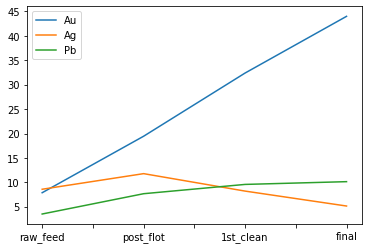

In [14]:
metals_concentrations.T.plot(kind = 'line')

After flotation we see all concentrations rising. This makes sense, as these are all metals and are pretty dense- if lighter materials have been removed, these will remain.

First cleaning process probably seperates by mass- lead and silver are heavier than gold. However, lead is still heavier than silver, so its concentration still increases, while more silver is removed.

Final cleaning does a better job- almost same concentration of lead, but gold has increased a lot.

Taking a look at a comparison for particle size distribution between our training and validation sets:

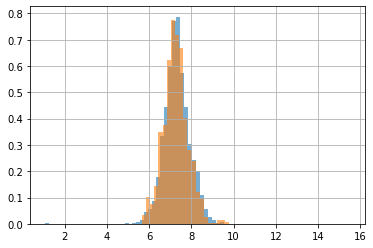

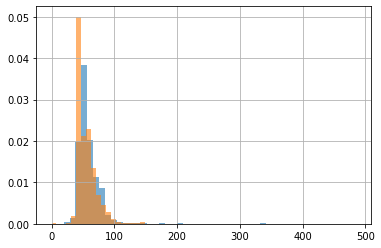

In [15]:
gold_train['primary_cleaner.input.feed_size'].hist(bins = 50, density = True, alpha = 0.6)
gold_test['primary_cleaner.input.feed_size'].hist(bins = 50, density = True, alpha = 0.6)
plt.show()

gold_train['rougher.input.feed_size'].hist(bins = 50, density = True, alpha = 0.6)
gold_test['rougher.input.feed_size'].hist(bins = 50, density = True, alpha = 0.6)
plt.show()

Distributions are similar in both sets.
There seems to be a slight skew in the final particle size for the test set.

Checking to see if there are any anomalies for the total concentration of metals-

In [16]:
total_metal = pd.DataFrame()

In [17]:
total_metal['raw_feed'] = gold_train['rougher.input.feed_au'] + gold_train['rougher.input.feed_ag'] + gold_train['rougher.input.feed_pb']
total_metal['post_flot'] = gold_train['rougher.output.concentrate_au'] + gold_train['rougher.output.concentrate_ag'] + gold_train['rougher.output.concentrate_pb']
total_metal['1st_clean'] = gold_train['primary_cleaner.output.concentrate_au'] + gold_train['primary_cleaner.output.concentrate_ag'] + gold_train['primary_cleaner.output.concentrate_pb']
total_metal['final'] = gold_train['final.output.concentrate_au'] + gold_train['final.output.concentrate_ag'] + gold_train['final.output.concentrate_pb']

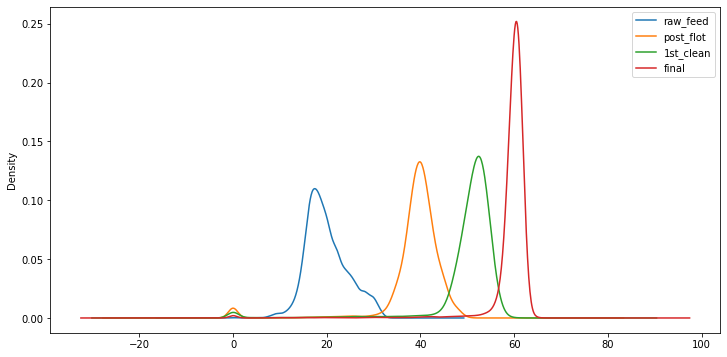

In [18]:
total_metal.plot(kind = 'kde', figsize = (12,6))
plt.show()

We see there is a small bump in distribution around the 0 mark. This may or may not be worth removing- depending on whether these recordings are errors.

If sometime a sample with little-to-no metal content makes it into the refining process, it makes a lot of sense to leave those in so the model could predict them. However, since it seems the values are actual 0's, it makes more sense that it is some kind of error. Rows with 0 total metals should be removed.

In [19]:
gold_train.drop(
    gold_train.query(
       ' (`rougher.input.feed_au` + `rougher.input.feed_ag` + `rougher.input.feed_pb`) == 0 or \
        (`rougher.output.concentrate_au` + `rougher.output.concentrate_ag` + `rougher.output.concentrate_pb`) == 0 or \
        (`primary_cleaner.output.concentrate_au` + `primary_cleaner.output.concentrate_ag` + `primary_cleaner.output.concentrate_pb`) == 0 or \
        (`final.output.concentrate_au` + `final.output.concentrate_ag` + `final.output.concentrate_pb`) == 0' 
    ).index, inplace =True
)

In [20]:
# Test set has no outputs
gold_test.drop(
    gold_train.query(
       ' (`rougher.input.feed_au` + `rougher.input.feed_ag` + `rougher.input.feed_pb`) == 0' 
    ).index, inplace =True
)

## Model Training

### Function For sMAPE

Defining a function for calculation of sMAPE-

In [21]:
def smape(y_true, y_pred):
    smape = np.mean(abs(y_pred - y_true) / ((abs(y_true) + abs(y_pred)) / 2)) * 100 
    return smape

In [22]:
def smape_final(y_true,y_pred):
    smape_out_rougher = smape(y_true[:,0],y_pred[:,0])
    smape_out_final =smape(y_true[:,1],y_pred[:,1])
    return 0.25*smape_out_rougher + 0.75*smape_out_final

### Cross-Validation

In [23]:
features_train = gold_train.drop(missing_columns, axis = 1)
features_train = features_train.drop(['date'], axis = 1)
targets_train = gold_train[['rougher.output.recovery', 'final.output.recovery']].to_numpy()

features_test = gold_test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis = 1)
targets_test = gold_test[['rougher.output.recovery', 'final.output.recovery']].to_numpy()

Now to cross validate different models-

In [24]:
smape_score = make_scorer(smape_final, greater_is_better=False)

In [25]:
lin_params = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]
             }
linreg_model = GridSearchCV(LinearRegression(), param_grid=lin_params, cv=5, scoring=smape_score, verbose=0, refit=True)
linreg_model.fit(features_train, targets_train)
linreg_model.cv_results_['mean_test_score']

array([-10.02932339, -10.02932339, -10.13900769, -10.13900769,
       -10.02932339, -10.02932339, -10.13900769, -10.13900769])

In [26]:
dectre_params = {'max_depth': range(5, 10, 5),
                       'min_impurity_decrease' : np.arange(.01, .20, .02),
                       'min_samples_split' : range(2, 10, 2)}
dectre_model = GridSearchCV(DecisionTreeRegressor(random_state = 1337), param_grid=dectre_params, cv=5, scoring=smape_score, verbose=0, refit=True)
dectre_model.fit(features_train, targets_train)
dectre_model.cv_results_['mean_test_score']

array([-11.4539995 , -11.00666002, -11.00337918, -10.96262562,
       -11.41290975, -11.00895686, -10.96619834, -10.96655409,
       -10.99749119, -10.96468944, -10.95932317, -10.96504519,
       -11.01007108, -10.96702069, -11.00190787, -10.96623893,
       -10.96899962, -10.97323436, -10.96751234, -10.96429376,
       -10.93899357, -10.94322396, -10.94064865, -10.94078278,
       -10.92537166, -10.92357811, -10.92035517, -10.92214873,
       -10.93474406, -10.93308463, -10.93552581, -10.93308898,
       -10.93015081, -10.9293647 , -10.93180588, -10.93194001,
       -10.94842877, -10.94778115, -10.95022233, -10.94944058])

In [29]:
randfor_params =  {'n_estimators' : range(10, 100, 30),
                        'max_depth' : range(10, 60, 10),
                        'min_impurity_decrease' : np.arange(.05, .25, .1)}
randfor_model = GridSearchCV(RandomForestRegressor(random_state = 1337), param_grid=randfor_params, cv=2, scoring=smape_score, verbose=0, refit=True)
randfor_model.fit(features_train, targets_train)
randfor_model.cv_results_['mean_test_score']

array([ -9.66415638,  -9.84566212,  -9.73685941,  -9.8011633 ,
        -9.52877848,  -9.74905659,  -9.8276909 ,  -9.89165086,
        -9.78407732,  -9.71882016,  -9.62047095,  -9.59491317,
        -9.91554698,  -9.81311823,  -9.95894718,  -9.4949335 ,
        -9.75448044,  -9.55968446,  -9.99618055,  -9.92660309,
        -9.80347696,  -9.91739898,  -9.50287994,  -9.56909105,
       -10.24723068,  -9.69914644,  -9.91462348,  -9.8672153 ,
        -9.43720487,  -9.63042778])

We see that RandomForestRegressor gives the best scores. Now to test it in front of our test set-

Selecting best hyperparameters:

In [30]:
randfor_model.best_params_

{'max_depth': 50,
 'min_impurity_decrease': 0.15000000000000002,
 'n_estimators': 40}

In [33]:
best_model = RandomForestRegressor(max_depth= 50, min_impurity_decrease= 0.15000000000000002, n_estimators= 40, random_state = 1337)
best_model.fit(features_train, targets_train)
pred = best_model.predict(features_test)
score = smape_final(targets_test, pred)
score

9.446083803424699

Not a bad result. Quite similar to training set.

As a sanity check, a comparison to a dummy model-

In [36]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, targets_train)
pred = dummy_model.predict(features_test)
score = smape_final(targets_test, pred)
score

9.831066377059802

Seems like our result is slightly better than a dummy model.

## Conclusions

Gold processing is an envolved process. There are many elements that need to be tracked- and not all of them belong in a machine model. Better understanding of the chemical process is probably required to choose which features should be fed into the machine.

With the given test set, a relatively big error is expected- recovery rates for the test set are showen to be slightly skewed relative to the given training set.

The final model created is able to produce decent results, but will likely improve if the scope for relevant features is narrowed further, as there will be less noise.

If given more runtime, hyperparameters can be tuned much futher, also probably producing better results.